Pls don't make more notebooks than this one...

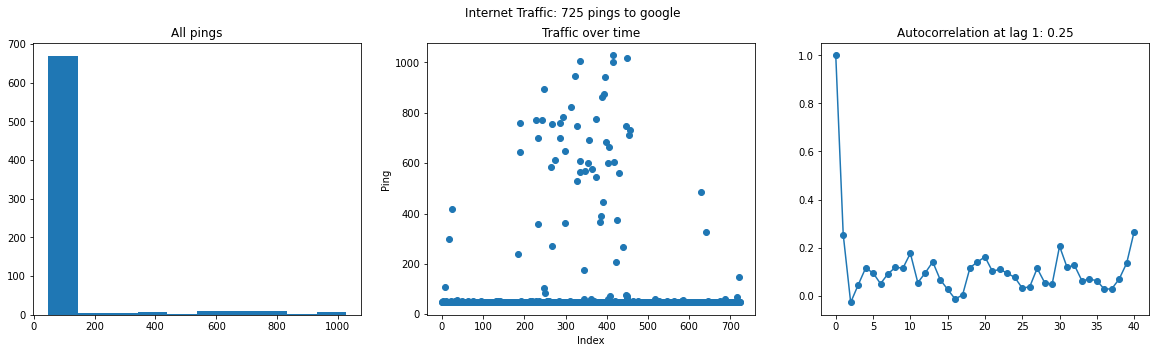

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools

traf = pd.read_csv('data/TEST_LOG', sep='\n', header=None, names=['speed'])['speed']
autocor = stattools.acf(traf, fft=False)

# Doing it this way bc I literally always forget
WIDTH = 20
HEIGHT = 5
fig, axs = plt.subplots(figsize=(WIDTH,HEIGHT), nrows=1,ncols=3)
fig.suptitle('Internet Traffic: {} pings to google'.format(traf.size))

axs[0].hist(traf);
axs[0].set_title('All pings');

axs[1].scatter(list(traf.index), traf);
axs[1].set_xlabel('Index');
axs[1].set_ylabel('Ping');
axs[1].set_title('Traffic over time')

axs[2].plot(autocor, marker='o')
axs[2].set_title('Autocorrelation at lag 1: {:.2f}'.format(autocor[1]));